# Import

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, brier_score_loss
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
import lightgbm as lgbm

seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [2]:
# data = pd.read_excel('./data/于小鹏 机器学习4.xlsx')
data = pd.read_excel('./data/于小鹏 机器学习5.xlsx')

In [3]:
data.head()

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.9079,0,0,1,58,1,1,5.68,51.2,43.1,3.2,42.3,1,19.0,14.9,42.1,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.5197,0,0,1,48,1,1,12.01,50.4,37.6,2.5,15.0,1,39.0,18.4,40.7,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.3092,0,0,2,76,0,1,8.99,52.1,37.0,1.7,1.8,0,19.0,14.0,41.9,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.4408,0,0,1,55,0,1,5.74,55.3,36.8,3.2,3.3,0,18.0,15.3,44.1,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.1053,1,0,1,51,1,1,9.02,60.3,32.8,3.7,2.1,0,12.0,14.4,41.0,10.9,1,2,2,0,4.7,1,1,1,0,1


In [4]:
data.drop(["生存状态（编码）", "TNM分期（编码汇总）"], axis=1, inplace=True)
data.describe()

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,淋巴清扫
count,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000
mean,27.1679,0.2646,1.4707,57.5573,0.2774,0.3893,6.5801,7.6089,2.9878,29.3976,10.5374,0.5827,40.7850,29.9694,40.7513,11.8659,1.1120,2.3486,1.0967,0.3435,5.3715,0.4580,0.1578,1.3690,0.6921
std,21.8705,0.4417,0.4998,9.8197,0.4483,0.5878,2.1395,13.9802,6.0066,133.3235,34.8370,0.4937,49.4194,58.3024,5.3410,1.5293,0.3157,0.5874,0.2959,0.4755,2.8162,0.4989,0.3650,0.5879,0.4622
min,1.5000,0.0000,1.0000,27.0000,0.0000,0.0000,2.2800,1.3200,0.1500,0.6500,0.2000,0.0000,6.0000,3.6000,24.4000,1.1000,1.0000,1.0000,1.0000,0.0000,0.7000,0.0000,0.0000,0.0000,0.0000
25%,10.7333,0.0000,1.0000,50.0000,0.0000,0.0000,5.1100,3.1000,1.2100,2.1700,1.5600,0.0000,17.0000,10.5000,37.6000,10.8000,1.0000,2.0000,1.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000
50%,22.0000,0.0000,1.0000,59.0000,0.0000,0.0000,6.3000,4.0700,1.5800,3.2000,2.8900,1.0000,25.0000,13.4700,41.2000,11.7000,1.0000,2.0000,1.0000,0.0000,5.0000,0.0000,0.0000,1.0000,1.0000
75%,38.0000,1.0000,2.0000,64.0000,1.0000,1.0000,7.6500,5.4600,2.0300,6.4000,5.2400,1.0000,41.0000,19.2000,44.0000,12.7000,1.0000,3.0000,1.0000,1.0000,7.0000,1.0000,0.0000,2.0000,1.0000
max,120.0667,1.0000,2.0000,83.0000,1.0000,2.0000,15.3400,87.2000,43.1000,1404.0000,338.0000,1.0000,370.0000,400.3000,78.3000,18.7000,2.0000,3.0000,2.0000,1.0000,17.0000,1.0000,1.0000,2.0000,1.0000


<AxesSubplot:xlabel='feature_15', ylabel='总体生存时间'>

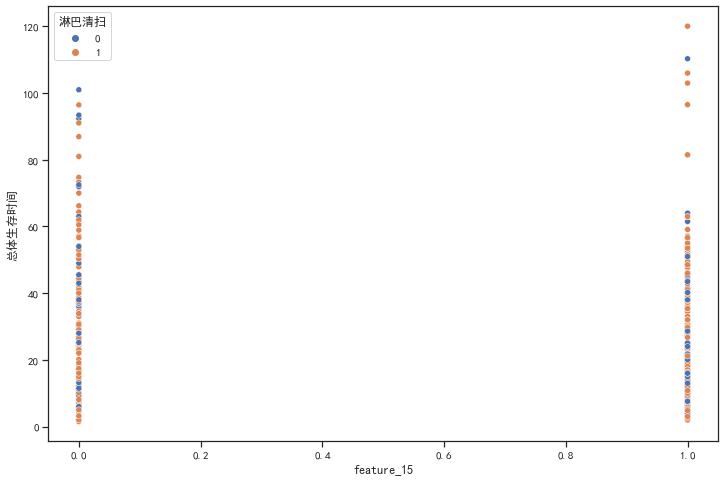

In [5]:
plt.figure(figsize=(12, 8))
# sns.scatterplot(x=original['feature_15'], y=original['总体生存时间'], hue=original['淋巴清扫'])
sns.scatterplot(x=data['feature_15'], y=data['总体生存时间'], hue=data['淋巴清扫'])

# preprocess

## Get class label

In [6]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

data['总体生存时间'] = data['总体生存时间'].apply(get_class)

Text(0.5, 1.0, 'Number of samples in each class')

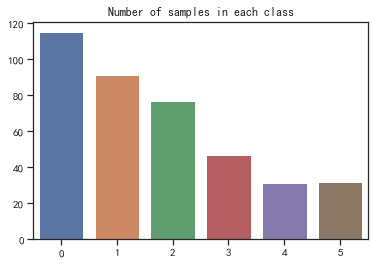

In [7]:
sns.barplot(y=data['总体生存时间'].value_counts().values, x=data['总体生存时间'].value_counts().index)
plt.title('Number of samples in each class')

In [8]:
df = data.copy()

with_ = df[df['淋巴清扫'] == 1]
without_ = df[df['淋巴清扫'] == 0]

# with_ = pd.DataFrame(with_, columns=with_ftr)
# without_ = pd.DataFrame(without_, columns=without_ftr)

with_.drop(['淋巴清扫'], axis=1, inplace=True)
without_.drop(['淋巴清扫'], axis=1, inplace=True)

In [9]:
with_

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28
0,0,0,1,58,1,1,5.68,51.20,43.10,3.20,42.30,1,19.0,14.90,42.10,11.9,1,2,2,0,3.2,1,0,1
1,1,0,1,48,1,1,12.01,50.40,37.60,2.50,15.00,1,39.0,18.40,40.70,13.0,1,1,2,0,8.0,1,0,0
2,2,0,2,76,0,1,8.99,52.10,37.00,1.70,1.80,0,19.0,14.00,41.90,12.6,1,1,1,0,5.1,1,0,1
4,4,0,1,51,1,1,9.02,60.30,32.80,3.70,2.10,0,12.0,14.40,41.00,10.9,1,2,2,0,4.7,1,1,1
5,1,0,2,45,1,1,5.79,60.40,31.80,1.60,9.20,1,37.0,7.90,43.10,11.6,1,2,1,0,9.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0,0,1,59,0,0,6.20,4.80,0.78,15.64,4.79,1,20.0,12.70,43.70,13.6,1,2,1,0,10.9,1,0,1
385,2,0,1,61,1,1,6.88,5.36,0.72,17.00,1.45,1,17.0,12.70,41.40,12.6,1,3,1,0,10.0,0,0,1
386,0,1,2,47,0,0,4.63,3.63,0.69,2.35,3.45,1,74.0,46.20,38.40,13.5,1,3,1,1,4.5,1,0,2
387,4,0,2,75,0,1,4.96,2.82,0.67,11.20,3.25,1,18.8,11.60,35.00,9.5,1,2,1,1,10.0,0,0,1


## Nomalization

In [10]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def scale(scaler, df):
    x = df.iloc[:, 1:].values
    y = df.iloc[:, 0].values
    
    x = scaler.fit_transform(x)
    # y = scaler.fit_transform(y.reshape(-1, 1))
    return x, y

In [11]:
with_x, with_y = scale(scaler, with_)
without_x, without_y = scale(scaler, without_)


## Split into training set and test set

In [12]:
# 数据5清扫组seed=1，数据4未清扫组不用seed
with_train_x, with_test_x, with_train_y, with_test_y = train_test_split(with_x, with_y, test_size=0.1, random_state=1)
without_train_x, without_test_x, without_train_y, without_test_y = train_test_split(without_x, without_y, test_size=0.2)
with_train_x.shape, with_test_x.shape


((244, 23), (28, 23))

In [13]:
without_train_x.shape, without_test_x.shape

((96, 23), (25, 23))

In [14]:
with_test_y, without_test_y

(array([1, 0, 0, 0, 4, 0, 5, 5, 5, 4, 1, 2, 4, 2, 4, 0, 1, 0, 2, 1, 3, 5,
        1, 0, 1, 3, 1, 4]),
 array([4, 3, 2, 2, 1, 3, 3, 2, 0, 2, 0, 0, 2, 1, 3, 0, 5, 0, 0, 0, 1, 1,
        0, 2, 1]))

# Model

In [15]:
def clf_model_eval(name, model, x, y, test_x, test_y, TNM=True):
    K = 16
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    train_acc = []
    train_precision = []
    train_recall = []
    train_f1 = []
    train_auc = []

    # 多折交叉验证
    for train_idx, valid_idx in kf.split(x, y):
        train_x, valid_x = x[train_idx], x[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        model.fit(train_x, train_y)
        
        # 对多折验证中的测试数据进行验证，可以不返回
        pred = model.predict(valid_x)
        proba = model.predict_proba(valid_x)
        train_acc.append(accuracy_score(valid_y, pred))
        train_precision.append(precision_score(valid_y, pred, average="macro"))
        train_recall.append(recall_score(valid_y, pred, average="macro"))
        train_f1.append(f1_score(valid_y, pred, average="macro"))
        train_auc.append(roc_auc_score(valid_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro'))
    
    # pred_proba = model.predict_proba(test_x)
    # return np.mean(acc), np.mean(precision), np.mean(recall), np.mean(f1), np.mean(auc), pred_proba
    train_res = pd.DataFrame([train_acc, train_precision, train_recall, train_f1, train_auc], index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
    if TNM:
        train_res.to_csv('./CV_result/清扫组/{}_{}折交叉验证结果.csv'.format(name, K))
    else:
        train_res.to_csv('./CV_result/未清扫组/{}_{}折交叉验证结果.csv'.format(name, K))
    
    # model.fit(x, y)
    # 对测试集数据进行验证
    pred = model.predict(test_x)
    proba = model.predict_proba(test_x)

    acc = accuracy_score(test_y, pred)
    precision = precision_score(test_y, pred, average="macro")
    recall = recall_score(test_y, pred, average="macro")
    f1 = f1_score(test_y, pred, average="macro")
    auc = roc_auc_score(test_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro')
    
    test_res = [acc, precision, recall, f1, auc]
    pred_proba = model.predict_proba(test_x)

    return test_res, pred_proba

In [16]:
clf = {
    "MLP": MLPClassifier(learning_rate="adaptive", max_iter=500),
    "SupportVectorMachine": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "GBDT": lgbm.LGBMClassifier(objective="multiclass"),
}

# Results of classification

In [17]:
with_proba = {}
without_proba = {}
with_test_results = {}
without_test_results = {}

for name, model in clf.items():
    test_res, proba = clf_model_eval(
        name,
        model,
        with_train_x,
        with_train_y,
        with_test_x,
        with_test_y
    )
    with_test_results[name] = test_res
    with_proba[name] = proba
    
for name, model in clf.items():
    test_res, proba = clf_model_eval(
        name,
        model,
        without_train_x,
        without_train_y,
        without_test_x,
        without_test_y,
        TNM=False
    )
    without_test_results[name] = test_res
    without_proba[name] = proba

In [18]:
df1 = pd.DataFrame(with_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df1.T.to_csv('./CV_result/清扫组/测试集结果.csv')
df1.T

,accuracy,precision,recall,f1,auc
MLP,0.5000,0.5417,0.4298,0.4318,0.7368
SupportVectorMachine,0.3571,0.1667,0.2381,0.1826,0.6749
RandomForest,0.3214,0.1360,0.2143,0.1538,0.6920
KNeighbors,0.4286,0.3889,0.3865,0.3655,0.6891
GBDT,0.2857,0.2765,0.2000,0.1865,0.6833


In [19]:
df2 = pd.DataFrame(without_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df2.T.to_csv('./CV_result/未清扫组/测试集结果.csv')
df2.T

,accuracy,precision,recall,f1,auc
MLP,0.20,0.1548,0.1319,0.1421,0.6293
SupportVectorMachine,0.36,0.2158,0.2333,0.2114,0.4619
RandomForest,0.28,0.1889,0.2042,0.1810,0.6305
KNeighbors,0.28,0.1499,0.1778,0.1591,0.6521
GBDT,0.24,0.2044,0.3292,0.2199,0.6389


# Plot

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。(micro)

第二种方式为：将每一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。（macro）

In [21]:
def get_roc_data(name, pred_proba, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    bs = []
    for i in range(6):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        bs.append(brier_score_loss(y_test[:, i], pred_proba[:, i], pos_label=i))

    
    # micro
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(6):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # 平均AUC
    mean_tpr /= 6
    fpr = all_fpr
    tpr = mean_tpr
    auc_ = auc(fpr, tpr)
    return fpr, tpr, auc_, roc_auc, bs

In [22]:
with_y_test = label_binarize(with_test_y, classes=[0, 1, 2, 3, 4, 5]) 
without_y_test = label_binarize(without_test_y, classes=[0, 1, 2, 3, 4, 5]) 

w_fpr = {}
w_tpr = {}
w_auc = {}
w_cindex = {}
w_bs = {}
wo_cindex = {}
wo_bs = {}
wo_fpr = {}
wo_tpr = {}
wo_auc = {}

for name, pred_proba in with_proba.items():
    w_fpr[name], w_tpr[name], w_auc[name], w_cindex[name], w_bs[name] = get_roc_data(name, pred_proba, with_y_test)

for name, pred_proba in without_proba.items():
    wo_fpr[name], wo_tpr[name], wo_auc[name], wo_cindex[name], wo_bs[name] = get_roc_data(name, pred_proba, without_y_test)

## ROC

In [23]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure(figsize=(10, 7))
    lw = 2
    colors = plt.cm.get_cmap("Dark2")
    plt.plot(
        fpr["MLP"],
        tpr["MLP"],
        # color=colors(0),
        lw=lw,
        label="MLP_AUC (area = %0.2f)" % roc_auc["MLP"],
    )
    plt.plot(
        fpr["SupportVectorMachine"],
        tpr["SupportVectorMachine"],
        # color=colors(1),
        lw=lw,
        label="SupportVectorMachine_AUC (area = %0.2f)" % roc_auc["SupportVectorMachine"],
    )
    plt.plot(
        fpr["RandomForest"],
        tpr["RandomForest"],
        # color=colors(2),
        lw=lw,
        label="RandomForest_AUC (area = %0.2f)" % roc_auc["RandomForest"],
    )
    plt.plot(
        fpr["KNeighbors"],
        tpr["KNeighbors"],
        # color=colors(3),
        lw=lw,
        label="KNeighbors_AUC (area = %0.2f)" % roc_auc["KNeighbors"],
    )
    plt.plot(
        fpr["GBDT"],
        tpr["GBDT"],
        # color=colors(4),
        lw=lw,
        label="GBDT_AUC (area = %0.2f)" % roc_auc["GBDT"],
    )
    plt.plot([0, 1], [0, 1], color="#9DA9B4", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if switch:
        plt.title(f"ROC Curve of Different Models", fontsize=16)
    else:
        plt.title("ROC Curve of Different Models", fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

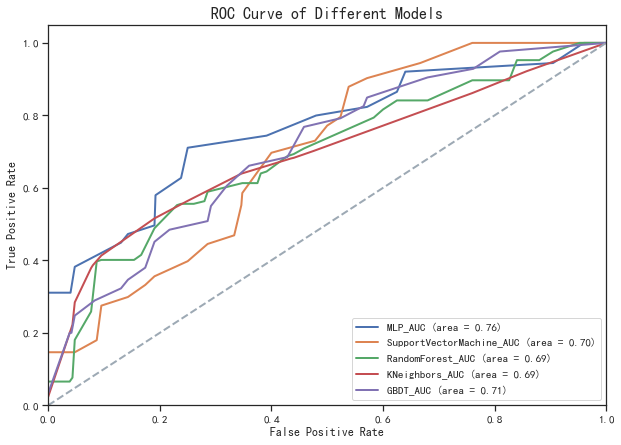

In [24]:
draw_roc(w_fpr, w_tpr, w_auc)   # with

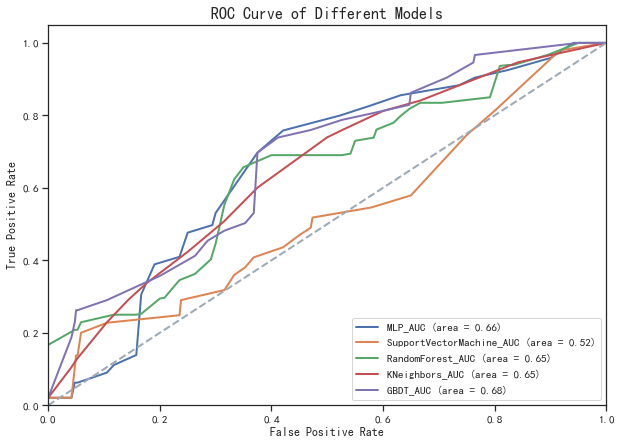

In [25]:
draw_roc(wo_fpr, wo_tpr, wo_auc, switch=False)  # without

## Discrimination and Calibration

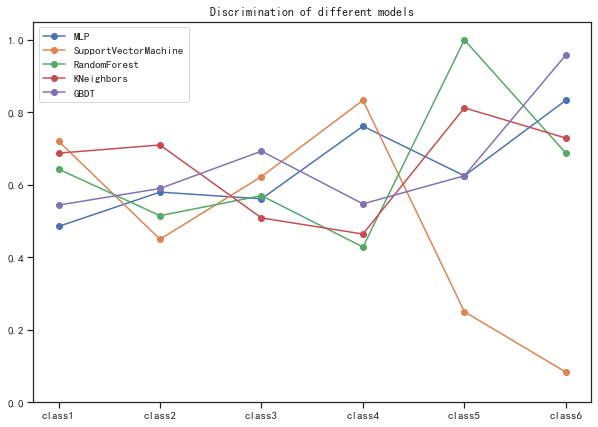

In [38]:
plt.figure(figsize=(10, 7))
# # w_cindex
# plt.plot(w_cindex["MLP"].values(), "o-", label="MLP")
# plt.plot(w_cindex["SupportVectorMachine"].values(), "o-", label="SupportVectorMachine")
# plt.plot(w_cindex["RandomForest"].values(), "o-", label="RandomForest")
# plt.plot(w_cindex["KNeighbors"].values(), "o-", label="KNeighbors")
# plt.plot(w_cindex["GBDT"].values(), "o-", label="GBDT")

# wo_cindex
plt.plot(wo_cindex["MLP"].values(), "o-", label="MLP")
plt.plot(wo_cindex["SupportVectorMachine"].values(), "o-", label="SupportVectorMachine")
plt.plot(wo_cindex["RandomForest"].values(), "o-", label="RandomForest")
plt.plot(wo_cindex["KNeighbors"].values(), "o-", label="KNeighbors")
plt.plot(wo_cindex["GBDT"].values(), "o-", label="GBDT")

xlabel = ["class1", "class2", "class3", "class4", "class5", "class6"]
plt.xticks(range(0, 6), xlabel)
plt.ylim([0.0, 1.05])
plt.legend()
plt.title("Discrimination of different models")
plt.show()

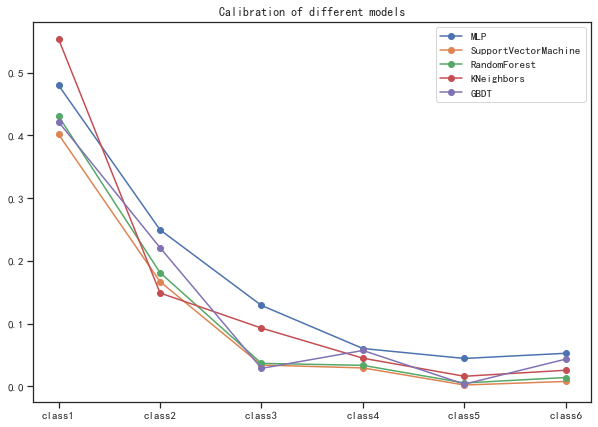

In [39]:
plt.figure(figsize=(10, 7))

# # w_bs
# plt.plot(w_bs["MLP"], "o-", label="MLP")
# plt.plot(w_bs["SupportVectorMachine"], "o-", label="SupportVectorMachine")
# plt.plot(w_bs["RandomForest"], "o-", label="RandomForest")
# plt.plot(w_bs["KNeighbors"], "o-", label="KNeighbors")
# plt.plot(w_bs["GBDT"], "o-", label="GBDT")

# wo_bs
plt.plot(wo_bs["MLP"], "o-", label="MLP")
plt.plot(wo_bs["SupportVectorMachine"], "o-", label="SupportVectorMachine")
plt.plot(wo_bs["RandomForest"], "o-", label="RandomForest")
plt.plot(wo_bs["KNeighbors"], "o-", label="KNeighbors")
plt.plot(wo_bs["GBDT"], "o-", label="GBDT")

xlabel = ["class1", "class2", "class3", "class4", "class5", "class6"]
plt.xticks(range(0, 6), xlabel)
# plt.ylim([0.0, 1.05])
plt.legend()
plt.title("Calibration of different models")
plt.show()

# SHAP

使用清扫组数据进行机器学习模型可解释性探索

In [40]:
import shap
ftr_names = with_.columns[1:]
# X = with_.iloc[:, 1:]
X = without_.iloc[:, 1:]

In [41]:
shap.initjs()
explainer = shap.TreeExplainer(clf['GBDT'])
shap_values = explainer.shap_values(X)

6类  
244个训练样本  
23项特征

In [42]:
print(len(shap_values))
print(shap_values[0].shape)

6
(121, 23)


单样本特征影响图：
- 横轴为SHAP值
- 蓝色代表该特征对预测有负向影响（箭头朝左，SHAP值减少），红色代表该特征对预测有正向影响（箭头朝右，SHAP值增加）

In [43]:
# # 针对分类的第1类，对第一个样本进行解释
# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:] , X.iloc[0,:])

In [44]:
# # 针对分类的第2类，对第一个样本进行解释
# shap.force_plot(explainer.expected_value[1], shap_values[1][:50,:], X.iloc[:50,:])

概括图，该图是对全部样本全部特征的shap值进行求和，可以反映出特征重要性及每个特征对样本类别预测的贡献。
- 对每个特征的SHAP值取绝对值平均，得到特征重要性分布

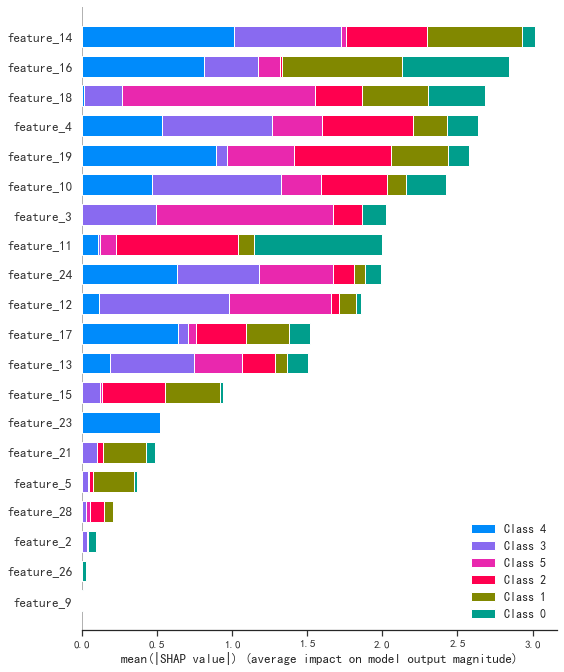

In [45]:
shap.summary_plot(shap_values, X)

In [46]:
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = ftr_names
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")
print_feature_importances_random_forest(clf["GBDT"])

feature_13 -> 182.0000
feature_19 -> 161.0000
feature_18 -> 148.0000
feature_14 -> 146.0000
feature_4 -> 141.0000
feature_12 -> 141.0000
feature_10 -> 136.0000
feature_11 -> 119.0000
feature_16 -> 119.0000
feature_24 -> 113.0000
feature_17 -> 101.0000
feature_3 -> 73.0000
feature_15 -> 41.0000
feature_28 -> 28.0000
feature_23 -> 22.0000
feature_5 -> 21.0000
feature_21 -> 17.0000
feature_2 -> 10.0000
feature_26 -> 2.0000
feature_9 -> 1.0000
feature_20 -> 0.0000
feature_22 -> 0.0000
feature_27 -> 0.0000
